Installing Dependencies and imports

In [3]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install mlxtend==0.16.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
import sys

from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocessing and Cleaning Data

In [6]:
file = open('/content/drive/My Drive/data.txt')
lines = file.readlines()

processedList = []

for line in lines:
  if (line[0]!='@'):
    line = line.split(',')
    temp = [line[0], line[1], line[2], line[3], line[4][0]]
    processedList.append(temp)

In [7]:
columns = ['series', 'x', 'y', 'z', 'action']
data = pd.DataFrame(data = processedList, columns = columns)
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')
data['action'] = data['action'].astype('float')
df = data.drop(['series'], axis = 1).copy()
df.head()

,x,y,z,action
0,0.47,0.69,0.76,1.0
1,0.47,0.71,0.77,1.0
2,0.47,0.71,0.78,1.0
3,0.47,0.70,0.77,1.0
4,0.48,0.69,0.77,1.0


In [8]:
df['action'].value_counts()

3.0    5160
4.0    4560
2.0    4120
1.0    3960
Name: action, dtype: int64

In [9]:
actions = df['action'].value_counts().index
actions

Float64Index([3.0, 4.0, 2.0, 1.0], dtype='float64')

Visualizing The Collected Time Series Data

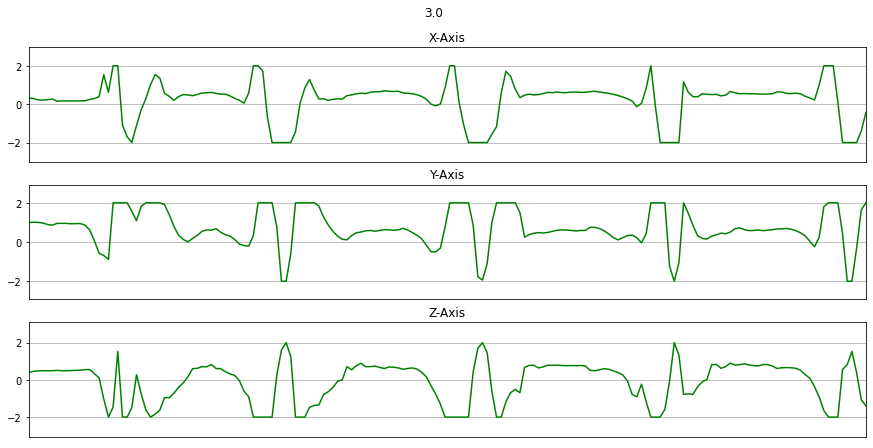

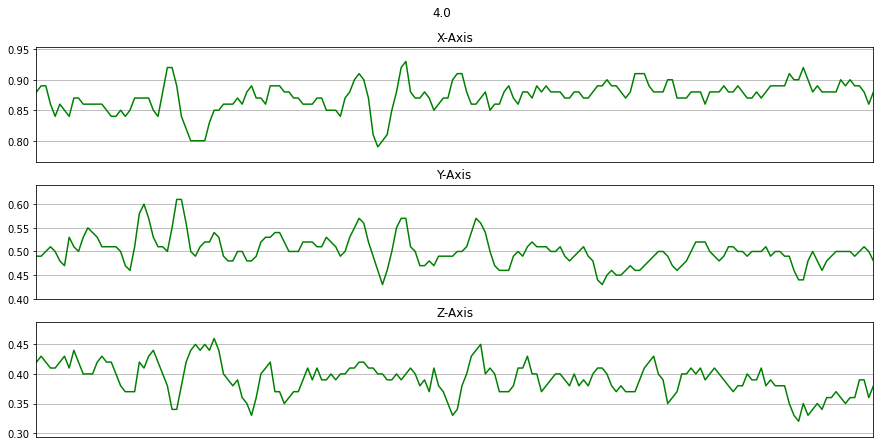

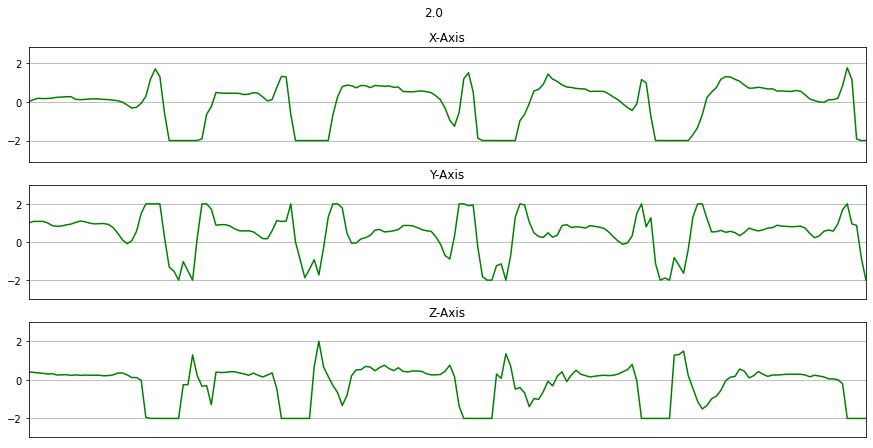

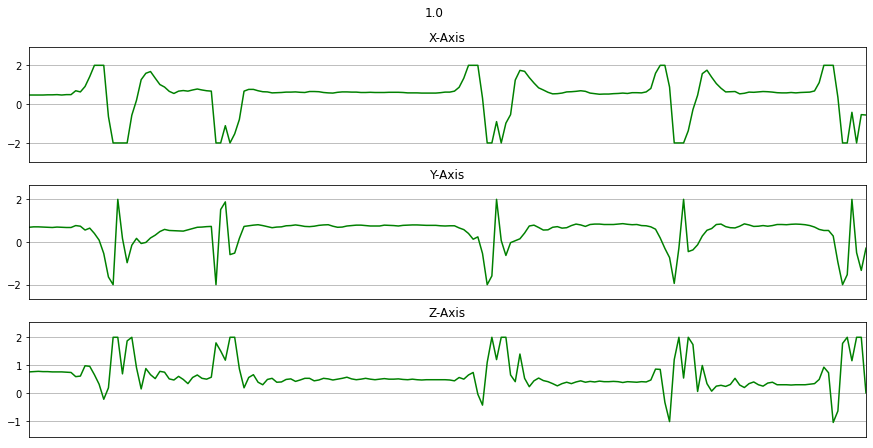

In [10]:
def plot_activity(action, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data.index, data['x'], 'X-Axis')
    plot_axis(ax1, data.index, data['y'], 'Y-Axis')
    plot_axis(ax2, data.index, data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(action)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in actions:
    data_for_plot = data[(data['action'] == activity)][:180]
    plot_activity(activity, data_for_plot)

Labeling Our Data

In [11]:
label = LabelEncoder()
df['label'] = label.fit_transform(df['action'])
df.head()

,x,y,z,action,label
0,0.47,0.69,0.76,1.0,0
1,0.47,0.71,0.77,1.0,0
2,0.47,0.71,0.78,1.0,0
3,0.47,0.70,0.77,1.0,0
4,0.48,0.69,0.77,1.0,0


In [12]:
print(df.head())

      x     y     z  action  label
0  0.47  0.69  0.76     1.0      0
1  0.47  0.71  0.77     1.0      0
2  0.47  0.71  0.78     1.0      0
3  0.47  0.70  0.77     1.0      0
4  0.48  0.69  0.77     1.0      0


In [13]:
label.classes_

array([1., 2., 3., 4.])

Spliting, Scaling, and Shaping the Data

In [14]:
X = df[['x', 'y', 'z']]
y = df['label']

In [15]:
scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head()

,x,y,z,label
0,0.47,0.69,0.76,0
1,0.47,0.71,0.77,0
2,0.47,0.71,0.78,0
3,0.47,0.70,0.77,0
4,0.48,0.69,0.77,0


In [16]:
frame_size = 60
hop_size = 60

In [17]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((296, 60, 3), (296,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((236, 60, 3), (60, 60, 3))

In [19]:
X_train = X_train.reshape(236, 60, 3, 1)
X_test = X_test.reshape(60, 60, 3, 1)
X_train.shape #why is this reshape important

(236, 60, 3, 1)

Training LSTM Model

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Activation, Dense, Dropout, Flatten

In [21]:
model = Sequential() # model type
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax')) #fix thisss

In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
8/8 [==============================] - 3s 114ms/step - loss: 1.2835 - accuracy: 0.3856 - val_loss: 0.9511 - val_accuracy: 0.7333
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 0.8253 - accuracy: 0.8051 - val_loss: 0.5661 - val_accuracy: 0.9000
Epoch 3/10
8/8 [==============================] - 0s 36ms/step - loss: 0.4657 - accuracy: 0.8941 - val_loss: 0.2698 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: 0.2715 - accuracy: 0.9322 - val_loss: 0.1407 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 0s 41ms/step - loss: 0.1953 - accuracy: 0.9449 - val_loss: 0.0811 - val_accuracy: 0.9667
Epoch 6/10
8/8 [==============================] - 0s 39ms/step - loss: 0.1208 - accuracy: 0.9703 - val_loss: 0.0747 - val_accuracy: 0.9667
Epoch 7/10
8/8 [==============================] - 0s 28ms/step - loss: 0.1049 - accuracy: 0.9703 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 8/10
8/8 [==========

In [24]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

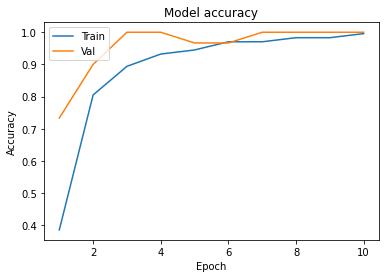

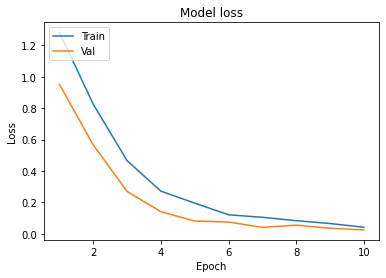

In [25]:
plot_learningCurve(history, 10)

Converting LSTM model to .jason using Tensorflowjs

In [26]:
pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')

Evaluating LSTM Model + Confussion Matrix

In [28]:
import mlxtend                                                          
print(mlxtend.__version__)

0.16.0


In [29]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [30]:
y_pred = model.predict(X_test)
print(y_pred[0])

2/2 [==============================] - 0s 13ms/step
[1.0689268e-02 6.3909206e-06 1.8528833e-04 9.8911911e-01]


In [31]:
y_pred_class = np.argmax(y_pred, axis=1) 
print(y_pred_class)

[3 2 2 2 0 3 2 1 2 0 3 2 1 0 1 2 1 3 2 0 2 0 0 0 0 2 1 1 0 1 2 3 3 0 1 3 1
 0 3 2 1 2 1 3 3 2 1 3 1 0 2 1 2 2 0 2 3 3 3 3]


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9298ca1c40>)

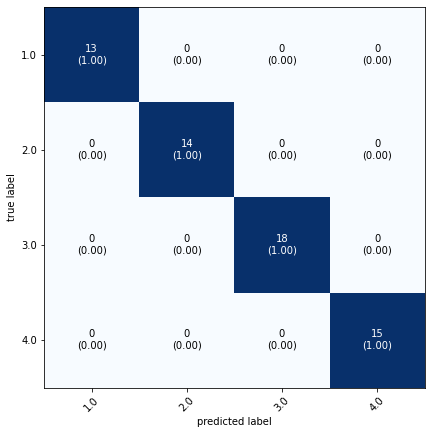

In [32]:
mat = confusion_matrix(y_test, y_pred_class)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))